<a href="https://colab.research.google.com/github/Siviwe25/Eskom_Analysis_Functions-/blob/master/Team_3_CPT_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-recommender-system-predict/tags.csv
/kaggle/input/edsa-recommender-system-predict/genome_scores.csv
/kaggle/input/edsa-recommender-system-predict/test.csv
/kaggle/input/edsa-recommender-system-predict/sample_submission.csv
/kaggle/input/edsa-recommender-system-predict/imdb_data.csv
/kaggle/input/edsa-recommender-system-predict/train.csv
/kaggle/input/edsa-recommender-system-predict/movies.csv
/kaggle/input/edsa-recommender-system-predict/genome_tags.csv
/kaggle/input/edsa-recommender-system-predict/links.csv


# EDSA Movie Recommendation Challenge: Team_3_CPT


# Introduction

**Problem** : Predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

# Comet

In [ ]:
!pip install comet_ml

In [ ]:
!pip3 install comet_ml

In [ ]:
# Import comet_ml in the top of your file
from comet_ml import Experiment

experiment = Experiment(api_key="27Am1kAXT7xNIExj5xU7o6rx0",
                        project_name="general", workspace="siviwe25")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/siviwe25/general/d307bda1db514174b3ba814535da76d0
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/siviwe25/general/5c7b397eaa734bf1bfbfd0d26cd0dd69



# Imports

In [ ]:
#Importing the required packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')
from collections import defaultdict
from wordcloud import WordCloud
from pandas import Series, DataFrame

# Exploratory Data Analysis

In this section we will be diving deep into the data and what it offers.
We will be doing thorough analysis and grabbing insights.

We will start by:
* Loading the data
* Viewing the data
* Checking for nan values
* Checking the shapes
* Adding visual comparisons

In [ ]:
# Loading the data
train = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/train.csv')
test = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/test.csv')
movies = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/movies.csv')
imdb = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/imdb_data.csv')

# Viewing the data
train.head()


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
# Checking the shape
train.shape


(10000038, 4)

In [ ]:
# Looking for nan values
train.isna().sum()


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
# Checking the shape
test.shape


(5000019, 2)

In [ ]:
# Looking for nan values
test.isna().sum()


userId     0
movieId    0
dtype: int64

Conclusion: Both the train and test datasets contain no missing values. We find the given data to be extremely clean and require little preprocessing.

# Visualising and grabbing insights:

We will dive deeper into the data and extract some insights which might help us solve the problem. 

We make use of graphs to visualise some key aspects of the datasets.


In [ ]:
# A function created for changing the labels.
def changingLabels(number):
    return str(number/10**6) + "M"
    

This bar graph visualises the distribution of ratings in the train data

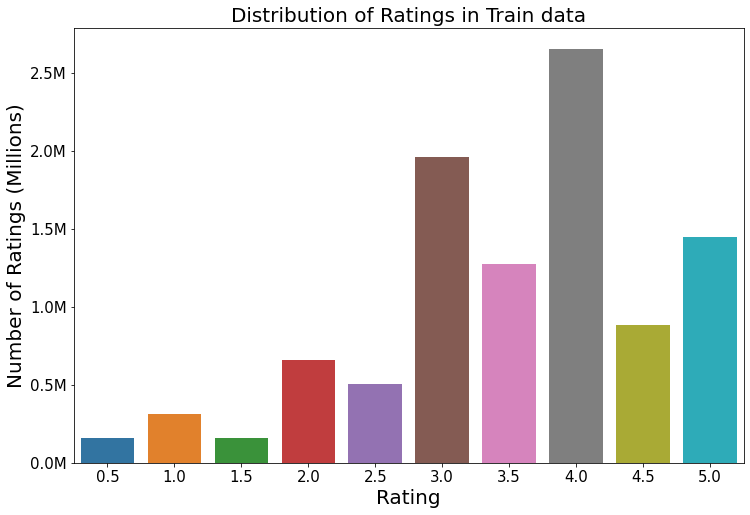

In [ ]:
# Plotting a bar graph to visualise distribution of ratings in the train data
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="rating", data=train)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize=15)
plt.title("Distribution of Ratings in Train data", fontsize=20)
plt.xlabel("Rating", fontsize=20)
plt.ylabel("Number of Ratings (Millions)", fontsize=20)
plt.show()


We can clearly see that Ratings equal to 4.0 are most common.

We believe that the reasons for this might be because it is likely that people who truely enjoyed a specific movie will never be 100% satisfied with the movie. Giving a 5.0 rating would indicate a truly perfect movie from the watchers perspective, which is very rare. The closest best thing to 5.0 without seeming bias is 4.0, therefore 4.0 ratings are most common.

In [ ]:
# Getting the number of ratings per movie
no_of_ratings_per_movie = train.groupby(by="movieId")["rating"].count().sort_values(ascending=False)


This line graph visualises the number of ratings per movie

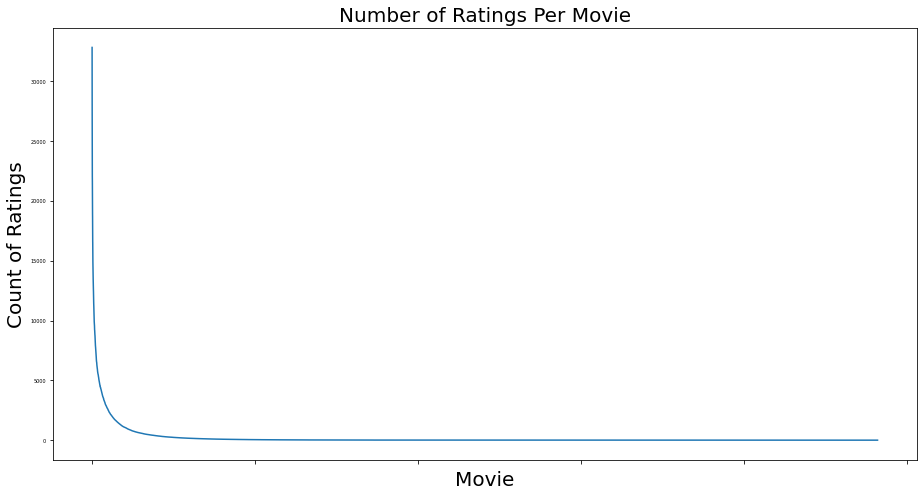

In [ ]:
# Plotting a line graph to visualise distribution of ratings in the train data
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes([0.1, 0.1, 1, 1])
plt.title("Number of Ratings Per Movie", fontsize=20)
plt.xlabel("Movie", fontsize=20)
plt.ylabel("Count of Ratings", fontsize=20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize=5)
axes.set_xticklabels([])
plt.show()


The above line graph shows that there are some movies that receive many ratings and some movies that receive very little votes.

We believe the reason for this can be the fact that some mainstream movies are way more popular and therefore receive a lot of attention compared to the other movies. 

In [ ]:
# Getting the number of movies rated per user
no_of_rated_movies_per_user = train.groupby(by="userId")["rating"].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head(10)


userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
109731     2671
49403      2670
92046      2579
110971     2288
30879      2284
Name: rating, dtype: int64

We can clearly see that user: '72315' has rated, by far, the most movies.

Both the PDF and CDF graphs following give us a representation of how many users actually rate the movies they have watched.

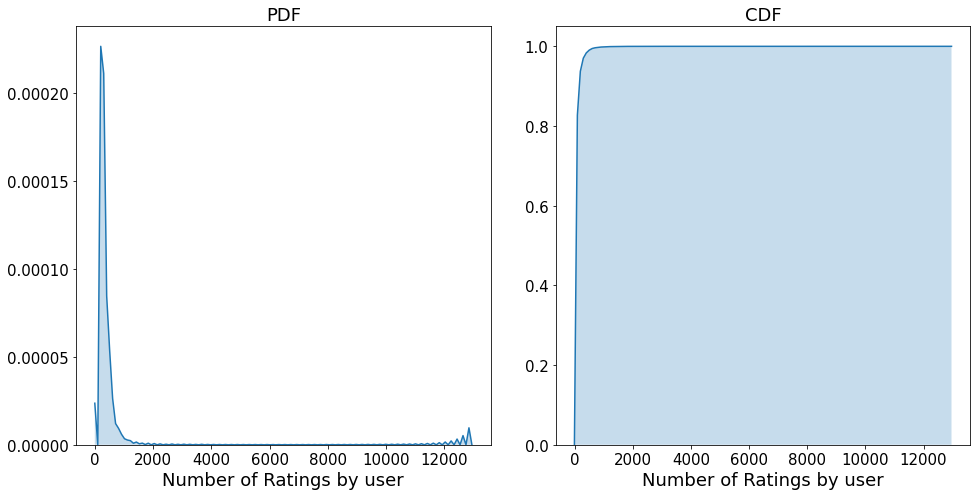

In [ ]:
# Plotting both an PDF and CDF to visualise movie ratings per user.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade=True, ax=axes[0])
axes[0].set_title("PDF", fontsize=18)
axes[0].set_xlabel("Number of Ratings by user", fontsize=18)
axes[0].tick_params(labelsize=15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade=True, cumulative=True, ax=axes[1])
axes[1].set_title("CDF", fontsize=18)
axes[1].set_xlabel("Number of Ratings by user", fontsize=18)
axes[1].tick_params(labelsize=15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()


 Both the PDF and CDF clearly indicate that users give very few ratings.

**Finding the most popular genre:**

We began by creating a list of all the genres.

In [ ]:
# We began by creating a list of all the genres.
temp = ""
for i in movies.genres:
    temp = temp+'|'+i
genres_list = list(set(temp.split('|')))
del genres_list[0]  # Data Cleaning
genres_list


['Film-Noir',
 'Adventure',
 'Comedy',
 'Animation',
 'War',
 'Drama',
 'IMAX',
 'Romance',
 'Horror',
 'Children',
 '(no genres listed)',
 'Musical',
 'Western',
 'Sci-Fi',
 'Thriller',
 'Documentary',
 'Crime',
 'Fantasy',
 'Action',
 'Mystery']

In [ ]:
# Split genres and create a new entry for each genre a movie falls into
s = movies['genres'].str.split('|').apply(Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'genres'
del movies['genres']
movies_split_genres = movies.join(s)


This way we can see all the genres a movie falls into more more clearly.

In [ ]:
movies_split_genres.head(7)


,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children


In [ ]:
# How many different genres do we have?
len(movies_split_genres['genres'].unique())

20

We have a movies dataset from 20 unique genres.

Next we will look at how many movies there are of each genre.

In [ ]:
# Group movies by genre using title as unique identifier and display all genres.
movies_genre = (pd.DataFrame(movies_split_genres.groupby('genres').title.nunique())).sort_values('title', ascending=True)
movies_genre.head(20)


,title
genres,
IMAX,195
Film-Noir,353
Musical,1054
Western,1399
War,1874
Fantasy,2731
Mystery,2925
Animation,2928
Children,2934


As you can see, the drama genre is by far the most popular genre in our dataset. We will be visualising this in a pie chart next.

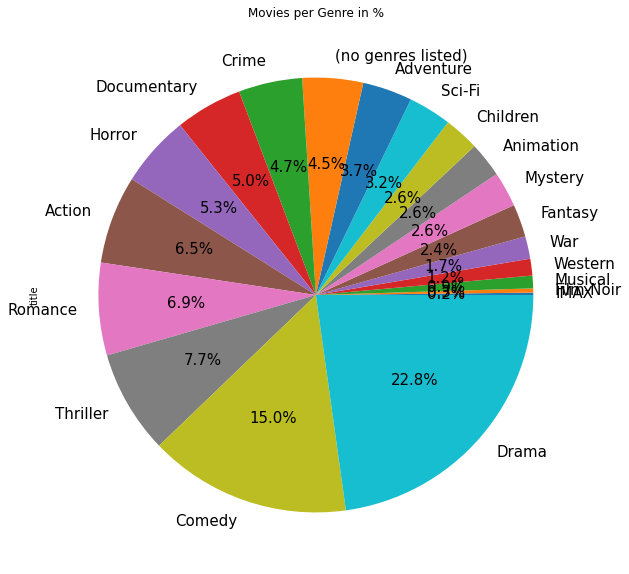

In [ ]:
# Pie chart showing percentage of movies in each genre
movies_genre['title'].plot.pie(title= 'Movies per Genre in %', figsize=(10,10), autopct='%1.1f%%',fontsize=15);



In this bar graph we can see that Drama and Comedy are by far most popular.

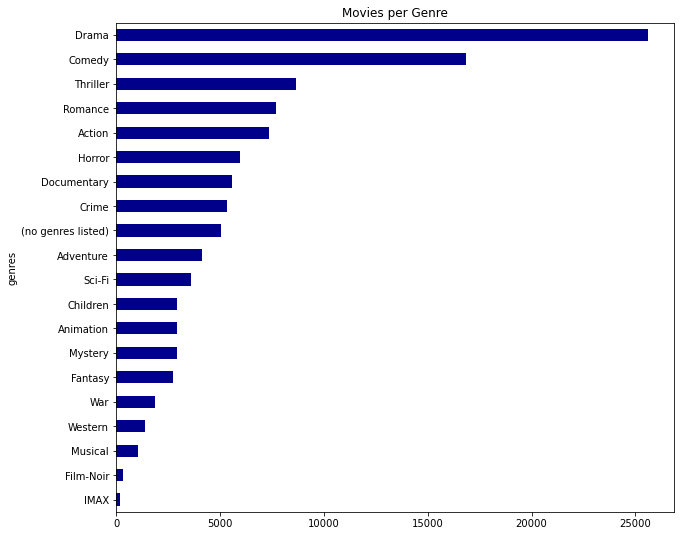

In [ ]:
# Display in bar chart
movies_genre['title'].plot.barh(title = 'Movies per Genre',color='DarkBlue', figsize=(10, 9));

Lastly we will take a glimpse of the imdb dataset.

We merged the imdb and movies dataframes for us to more effectively go about getting insights. 

In [ ]:
imd_movies = movies.merge(imdb, on='movieId')
imd_movies.head()

,movieId,title,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [ ]:
# Splitting title cast and create a new entry for each of the genre a movie falls into
z = imd_movies['title_cast'].str.split('|').apply(Series, 1).stack()
z.index = z.index.droplevel(-1)
z.name = 'title_cast'
del imd_movies['title_cast']
imd_movies_split_title_cast = imd_movies.join(z)

Here we can see which actors have starred in the most movies.

In [ ]:
imd_movies_split_title_cast['title_cast'].value_counts().head(15)

Samuel L. Jackson     79
Steve Buscemi         65
Robert De Niro        57
Willem Dafoe          55
Nicolas Cage          55
Gérard Depardieu      55
Christopher Walken    54
Keith David           54
Bruce Willis          54
Brian Cox             54
Richard Jenkins       53
Morgan Freeman        53
Danny Glover          53
Tom Wilkinson         53
Stanley Tucci         53
Name: title_cast, dtype: int64

As to be expected: Samuel L. Jackson, Steve Buscemi and Robert De Niro have appeared in most movies.

Here we can see which director has directed the most movies.

In [ ]:
imd_movies['director'].value_counts().head(15)

Woody Allen            26
Luc Besson             26
See full summary       25
Stephen King           23
William Shakespeare    18
Lars von Trier         15
Tyler Perry            15
Ki-duk Kim             15
Robert Rodriguez       14
David Mamet            13
Peter Farrelly         13
Alex Gibney            13
Sang-soo Hong          12
Olivier Assayas        12
Takeshi Kitano         12
Name: director, dtype: int64

Woody Allen and Luc Besson have directed the most movies.     
       

# Model Building

We will use a technique called ***collaborative filtering*** to make recommendations to movie watchers. Collaborative filtering is the most common technique used when it comes to building intelligent recommender systems that can learn to give better recommendations as more information about users is collected.Collaborative filtering provides many advantages over content-based filtering. A few of them are as follows: Not required to understand item content: The content of the items does not necessarily tell the whole story, such as movie type/genre, and so on.

We will not be implementing collaborative filtering from scratch. Instead, we will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

Most websites like Amazon, YouTube, and Netflix use collaborative filtering as a part of their sophisticated recommendation systems. We can use this technique to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users.

Our collaborative filtering model uses a **Single Value Decomposition (SVD)** algorithm:

One way to handle the scalability and sparsity issue created by colaborative filtering is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

The latent factor you might be wondering is a broad idea which describes a property or concept that a user or an item has. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. 

In [ ]:
# Run if running from colab
!pip install scikit-surprise

In [ ]:
# Importing the surprise packages we need
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(1, 5))


In [ ]:
# Setting up our data variable to use in our surprise pacakage
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)
cross_validate(NormalPredictor(), data, cv=2)
# cross_validate(SVD(), data, cv=2)


{'test_rmse': array([1.44276798, 1.44235619]),
 'test_mae': array([1.1504831 , 1.15025897]),
 'fit_time': (13.416467905044556, 17.268789529800415),
 'test_time': (82.15750980377197, 76.37890529632568)}

In [ ]:
kf = KFold(n_splits=3)
algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    

RMSE: 0.8458
RMSE: 0.8452
RMSE: 0.8463


Fitting our algorithm on the whole dataset.

In [ ]:
# After gridsearch. Best parameters : n_epochs=10, lr_all=0.005, reg_all=0.4
algo.fit(data.build_full_trainset())


In [ ]:
# run to create a pickle file
import pickle
# Pickle the model
model_save_path = "SVD_full_dataset.pkl"
with open(model_save_path, 'wb') as file:
  pickle.dump(algo, file)
  

In [ ]:
# This for loop generates a list containing all our predictions.
ratings = []
for _, row in test.iterrows():
    ratings.append(algo.predict(row.userId, row.movieId).est)

ratings[0:10]


[3.240743247651703,
 4.206082602730029,
 3.736132419505399,
 4.025949364732936,
 2.911411376491275,
 4.2185993309680105,
 4.223940343372361,
 3.5373301494425995,
 3.6273080815728687,
 3.849750964205453]

In [ ]:
# setting up our test dataframe for submission.
test['rating'] = ratings
test['Id'] = test[['userId', 'movieId']].astype(str).agg('_'.join, axis=1)
test.head()


,userId,movieId,rating,Id
0,1,2011,3.240743,1_2011
1,1,4144,4.206083,1_4144
2,1,5767,3.736132,1_5767
3,1,6711,4.025949,1_6711
4,1,7318,2.911411,1_7318


In [ ]:
# Creating our submission csv file. Score of 0.81885.
test_df = test.copy()
test_df.drop(columns=['movieId', 'userId'], inplace=True)
test_df.to_csv('Submission_5.csv', index=False)
test_df


,rating,Id
0,3.240743,1_2011
1,4.206083,1_4144
2,3.736132,1_5767
3,4.025949,1_6711
4,2.911411,1_7318
...,...,...
5000014,2.916967,162541_4079
5000015,3.753563,162541_4467
5000016,2.868134,162541_4980
5000017,3.063127,162541_5689


In [ ]:
ratings_dict = {'itemId': list(train.movieId),
                'userId': list(train.userId),
                'rating': list(train.rating)}

df = pd.DataFrame(ratings_dict)
df.head()


,itemId,userId,rating
0,57669,5163,4.0
1,5,106343,4.5
2,5459,146790,5.0
3,32296,106362,2.0
4,366,9041,3.0



The following function will create a pandas data frame which will consist of these columns:

UID: user-id

iid: item id

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [ ]:
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)


In [ ]:
df_predictions.head()


,uid,iid,rui,est,details,Iu,Ui,err
0,120831,3067,4.0,3.950800,{'was_impossible': False},38,746,0.049200
1,3794,104913,3.5,3.565788,{'was_impossible': False},99,916,0.065788
2,115056,96606,5.0,4.198245,{'was_impossible': False},82,264,0.801755
3,13411,377,3.0,3.620700,{'was_impossible': False},266,10967,0.620700
4,133629,1073,3.0,4.203781,{'was_impossible': False},120,7398,1.203781


# Evaluating our Model's predictive ability and accuracy:

By doing analysis on our Model's findings we can extract some important findings.

 # Top 10 best and worst predictions by model

 Here we can see our model's 10 best and worst predictions. This shows us where we have room for improvement.

In [ ]:
# Best and Worst predictions
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]


In [ ]:
# Viewing 10 best predictions
best_predictions


,uid,iid,rui,est,details,Iu,Ui,err
722659,2766,3435,5.0,5.0,{'was_impossible': False},168,1437,0.0
861705,134814,1732,5.0,5.0,{'was_impossible': False},350,7414,0.0
861628,128577,3593,1.0,1.0,{'was_impossible': False},370,1155,0.0
384533,46893,2868,1.0,1.0,{'was_impossible': False},100,105,0.0
2743543,81295,88125,5.0,5.0,{'was_impossible': False},9,3568,0.0
1482634,79095,1923,5.0,5.0,{'was_impossible': False},139,6559,0.0
2500731,162259,60069,5.0,5.0,{'was_impossible': False},38,7368,0.0
270825,137690,55232,5.0,5.0,{'was_impossible': False},101,756,0.0
1376030,141830,84152,5.0,5.0,{'was_impossible': False},276,2696,0.0
576752,147434,7013,5.0,5.0,{'was_impossible': False},130,485,0.0


In [ ]:
# Viewing 10 worst predictions
worst_predictions


,uid,iid,rui,est,details,Iu,Ui,err
1887925,24869,114552,0.5,5.0,{'was_impossible': False},1139,185,4.5
2006530,94158,333,0.5,5.0,{'was_impossible': False},244,2916,4.5
2144097,126203,858,0.5,5.0,{'was_impossible': False},21,13942,4.5
205958,38037,2357,0.5,5.0,{'was_impossible': False},25,594,4.5
2614295,101702,318,0.5,5.0,{'was_impossible': False},52,21891,4.5
1863395,86568,1221,0.5,5.0,{'was_impossible': False},35,8938,4.5
211135,77819,8972,0.5,5.0,{'was_impossible': False},68,2446,4.5
2205579,24869,8641,0.5,5.0,{'was_impossible': False},1139,2497,4.5
1008655,92916,296,0.5,5.0,{'was_impossible': False},46,21240,4.5
3263023,138439,2762,0.5,5.0,{'was_impossible': False},59,12387,4.5


# K Recommendations

Recall and precision at K Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.

#Conversion to binary

To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 3.5 as the threshold, which means any true rating above 3.5 will be considered relevant and below will be not relevant.

Deciding 'k'

In recommendation systems, we are interested in showing the top N items to users and so the best way is to compute precision and recall on top N values instead of calculating on all the items.

Definition of Relevant and Recommended
Relevant: True Rating > = 3.5

Irrelevant: True Rating < 3.5

Recommended item: Predicted Rating > = 3.5

Not Recommended item: Predicted Rating > = 3.5

Definition of Precision and Recall
Precision: It tries to answer "What proportion of positive identifications was actually correct?" i.e True positive / (True positive+False Positive) in RecSys we can say (number of recommended items at k that are relevant) / (number of recommended items at k)

Recall: It tries to answer "What proportion of actual positives were identified correctly?" i.e True positive / (True Positive+False Negative) in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)

While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.

In some circumstances, we might know that we need to maximize either recall or precision at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease.

However, in cases where we want to obtain an optimal blend of precision and recall, we can use F1 score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

f1 score = 2 * (precision * recall) / (precision + recall)

The below function computes precision and recall and F1 socre as explained above.

In [ ]:
#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)
final = []

for threshold in np.arange(0, 5.5, 0.5):
    tp=0
    fn=0
    fp=0
    tn=0
    temp = []

    for uid, _, true_r, est, _ in predictions:
        if(true_r>=threshold):
            if(est>=threshold):
                tp = tp+1
            else:
                fn = fn+1
        else:
            if(est>=threshold):
                fp = fp+1
            else:
                tn = tn+1   

        if tp == 0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * (precision * recall) / (precision + recall)  

    temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
    final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results


,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,3333346,0,0,0,1.000000,1.000000,1.000000
1,0.5,3333346,0,0,0,1.000000,1.000000,1.000000
2,1.0,3280858,52488,0,0,0.984254,1.000000,0.992064
3,1.5,3169212,139421,16820,7893,0.957861,0.997516,0.977286
4,2.0,3090914,162124,47444,32864,0.950162,0.989479,0.969422
5,2.5,2809429,285869,142315,95733,0.907644,0.967047,0.936405
6,3.0,2429143,267999,328626,307578,0.900636,0.887611,0.894076
7,3.5,1536396,362506,888620,545824,0.809097,0.737864,0.771841
8,4.0,703857,154283,1520422,954784,0.820212,0.424358,0.559331
9,4.5,124018,49685,2509282,650361,0.713966,0.160152,0.261619


As per the results above, the optimal value for threshold is 2.5.

The next step is to find the optimal K value, and to find if we have to first calculate precision and recall for all the K values(2-10) having threshold value 2.5.

Below is the function to calculate precision and recall at K.

In [ ]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls
    

In [ ]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})

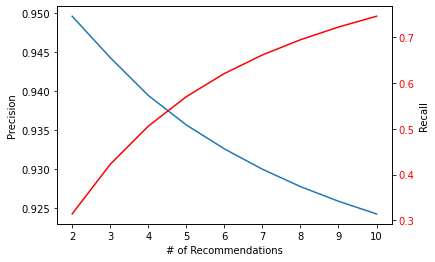

In [ ]:
Rec = []
Precision = []
Recall = []
for i in range(0, 9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')

for tl in plt2.get_yticklabels():
    tl.set_color('r')


As the graph states, Precision drops significantly when K=4

So we will consider the value of K to be 4.

 #  Testing Model's Recommendation Ability

As we know the optimal number of recommendations to provide, it's time to give recommendations to users. To do so we have to predict ratings for the movies which user have not yet watched.

Here we will be using build_anti_testset() method to get the data for testset as we have to predict ratings for the (user, item) pairs which are not present.

In [ ]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n
    

In [ ]:
all_pred = get_all_predictions(predictions)


As we have all the predicted rating, we'll subset to only top K movies for every user, where K is 4

In [ ]:
#To get top 4 recommendation
n = 4

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]
    

In [ ]:
tmp2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in all_pred.items() ]))
tmp2
tmp_transpose = tmp2.transpose()


In [ ]:
tmp_transpose


,0,1,2,3
120831,"(1193, 4.289396431510772)","(55442, 4.170481048306198)","(2762, 4.092727461426976)","(2571, 4.086603368871105)"
3794,"(1208, 4.081711477602463)","(1089, 4.040299251673699)","(1921, 4.021442674089149)","(4235, 4.001239699752892)"
115056,"(1089, 4.474930513973772)","(318, 4.451470789987054)","(608, 4.271436021328054)","(96606, 4.1982445908757775)"
13411,"(919, 4.147073708796219)","(7034, 3.966300289361904)","(6539, 3.944120129168072)","(5991, 3.8764840392470754)"
133629,"(3030, 4.910036961126144)","(947, 4.749580225119588)","(1131, 4.728058657490808)","(1250, 4.692030084477275)"
...,...,...,...,...
161420,"(593, 4.5539393408193)",NaN,NaN,NaN
14758,"(836, 3.5090464016818608)",NaN,NaN,NaN
68557,"(1704, 4.364413666605029)",NaN,NaN,NaN
144458,"(2296, 3.5195478604369304)",NaN,NaN,NaN


Now we have a dataframe which consits of top 4 movies recommended to every user.
Let's try one example and find recommendations for user 67.

Also in our streamlit app.

In [ ]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results
    

In [ ]:
user_id = 67
results = get_predictions(user_id)
results


0     (1270, 3.537249746934564)
1    (1097, 3.4615038096584367)
2    (2193, 3.2730051585766264)
3    (1967, 3.2438425578088386)
Name: 67, dtype: object

Above matrix is showing top "4" recommendations for user 67. (Movie-id, Predicted-Rating).
But we just need the movies not the ratings, so let's extract the movie id's from the result.

In [ ]:
recommended_movie_ids = []
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids


[1270, 1097, 2193, 1967]

Now as we have the movie-id's to be recommended, Let's find out the movie details of those id's by reading the movie data.

In [ ]:
movies = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/movies.csv')
movies.head()
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies


,movieId,title,genres
1070,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi
1237,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
1878,1967,Labyrinth (1986),Adventure|Fantasy|Musical
2103,2193,Willow (1988),Action|Adventure|Fantasy


In [ ]:
ratings_dict = {'itemId': list(train.movieId),
                'userId': list(train.userId),
                'rating': list(train.rating)}

df = pd.DataFrame(ratings_dict)
df.head()


,itemId,userId,rating
0,57669,5163,4.0
1,5,106343,4.5
2,5459,146790,5.0
3,32296,106362,2.0
4,366,9041,3.0


In [ ]:
temp = df[df['userId'] == 67].sort_values("rating", ascending = False)
temp.head()


,itemId,userId,rating
6344287,2571,67,5.0
3004,2193,67,4.0
2455852,891,67,4.0
9523893,2089,67,4.0
8360207,1752,67,4.0


In [ ]:
temp.shape


(49, 3)

We can see that user 67 have rated 49 movies

In [ ]:
history_movie_ids = temp['itemId']
user_history = movies[movies['movieId'].isin(history_movie_ids)]


In [ ]:
user_history[:n]


,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
18,19,Ace Ventura: When Nature Calls (1995),Comedy
43,44,Mortal Kombat (1995),Action|Adventure|Fantasy
108,110,Braveheart (1995),Action|Drama|War


Now we can compare the results with the user history and see how relevant the recommendations are.


Above is the user history and below the recommended movies

In [ ]:
recommended_movies


,movieId,title,genres
1070,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi
1237,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
1878,1967,Labyrinth (1986),Adventure|Fantasy|Musical
2103,2193,Willow (1988),Action|Adventure|Fantasy


The history of the user tells that they enjoy movies in the Adventure, Children,Animation, Drama, Comedy, Action and War genres. Our model recommends movies in the same genres, this gives us a good indication that our model has very good predictive/recommendation ability.

# Conclusion

Our model was able to give great recommendations for movies and accurately predict a user's rating towards a movie, before they have even seen it, using a Collaborative filtering algorithm.

As we assessed the overall performance of the model based on other non-statistical aspects we can conclude that the model has high predictive ability.

This has an immense economic potential for the service providers and provides a pleasant experience to the consumers of the content


# Ending Comet Experiment 

In [ ]:
f1 = f1_score(y_test, y_predsm,average='macro')
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')

In [ ]:
params = {"kernel": 'linear',"model_type": "SVC","stratify": True}

In [ ]:
params = {"model_type": "SVC","stratify": True}

metrics = {"f1": f1,"recall": recall,"precision": precision}

In [ ]:
# Log our parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/siviwe25/general/5c7b397eaa734bf1bfbfd0d26cd0dd69
COMET INFO:   Metrics [count]:
COMET INFO:     f1 [2]        : 0.036390232010076795
COMET INFO:     precision [2] : 0.7926365165058855
COMET INFO:     recall [2]    : 0.01862260121724774
COMET INFO:   Parameters:
COMET INFO:     model_type : SVC
COMET INFO:     stratify   : True
COMET INFO:   Uploads:
COMET INFO:     code                : 1 (18 KB)
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


# Appendix A

This section contains things that might have not worked, our previous models and some testing we did. Feel free to have a look at everything we attempted. 


In [ ]:
#from surprise.model_selection import GridSearchCV
#param_grid = {'n_epochs': [5, 10],'lr_all': [0.002, 0.005],'reg_all': [0.4, 0.6]}
#gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
#gs.fit(data)

# best RMSE score
#print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])


In [ ]:
#from surprise.model_selection import train_test_split

# Setting the data variable and using the Reader() object.
#data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
#trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
#algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)

# Train the algorithm on the trainset, and predict ratings for the testset
#algo.fit(trainset)
#predictions = algo.test(testset)

# Then compute RMSE
#accuracy.rmse(predictions)

In [ ]:
# Using algorithm with best 'rmse'
#algo = gs.best_estimator['rmse']

# Fitting it to our full trainset
#algo.fit(data.build_full_trainset())

In [ ]:
#ratings = []
#for _, row in test.iterrows():ratings.append(algo.predict(row.userId, row.movieId).est)

#ratings

In [ ]:
#results_df = pd.DataFrame.from_dict(gs.cv_results)
#results_df

Looking at the other data:

In [ ]:
#movies = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/movies.csv')
#genome_scores = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/genome_scores.csv')
#genome_tags = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/genome_tags.csv')
#imdb_data = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/imdb_data.csv')
#tags = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/tags.csv')
#links = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/links.csv')
#sample = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/sample_submission.csv')
